In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

from Bio import SeqIO,Phylo
import numpy as np

import glob,os,re,copy,math,pathlib

typeface='Arial'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

import importlib.machinery
import importlib.util
import baltic as bt

loader = importlib.machinery.SourceFileLoader('baltic', os.path.join(os.getcwd(), 'baltic_utils.py'))
spec = importlib.util.spec_from_loader(loader.name, loader)
bt_utils = importlib.util.module_from_spec(spec)
loader.exec_module(bt_utils)

base_path=pathlib.Path(os.path.abspath('')).parent
data_path=os.path.join(base_path, "data", "figure_4")

In [2]:
cfml_path='ClonalFrameML'

homoplasy_trees={}

for tree_path in glob.glob(os.path.join(data_path,'anello_80.0_cluster*_*.newick')):
    if 'chunk' not in tree_path and 'rename' not in tree_path and 'CFML' not in tree_path:
        
        print(tree_path)
        aln_path=tree_path.replace('.newick','.fasta')
        out_stem=tree_path.replace('.newick','_CFML')
        bt_utils.reconstruct_ancestral_states(cfml_path,aln_path,tree_path,2.0,out_stem)
        
        genus=tree_path.split('_')[-1].split('.')[0]
        
        ll=bt.loadNexus(tree_path.replace('.newick','_CFML.annotated.tree'),verbose=False)
        ll.treeStats()
        
        for k in ll.Objects:
            if 'sequence' in k.parent.traits:
                pseq=k.parent.traits['sequence']
                seq=k.traits['sequence']
                for site,pair in enumerate(zip(pseq,seq)):
                    a,b=pair
                    invalid=['N','-']
                    if a!=b and a not in invalid and b not in invalid:
                        if 'mutations' not in k.traits: k.traits['mutations']=[]
                        k.traits['mutations'].append('%s%d%s'%(a,site,b))
        
        homoplasy_trees[genus]=ll

/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster08_Alpha.newick

Tree height: 0.173954
Tree length: 0.874672
strictly bifurcating tree

Numbers of objects in tree: 45 (22 nodes and 23 leaves)


ClonalFrameML /Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster08_Alpha_renamed.newick /Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster08_Alpha_renamed.fasta /Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster08_Alpha_CFML -imputation_only true -kappa 2.0


Tree height: 0.173953
Tree length: 0.874670
strictly bifurcating tree
annotations present

Numbers of objects in tree: 45 (22 nodes and 23 leaves)

/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster158_Gamma.newick

Tree height: 0.281381
Tree length: 1.044068
strictly bifurcating tree

Numbers of objects in tree: 19 (9 nodes and 10 

In [3]:
from collections import Counter

homoplasy_branches={}
synapomorphy_branches={}

for genus in homoplasy_trees:
    ll=homoplasy_trees[genus]
    homoplasy_branches[genus]={}
    synapomorphy_branches[genus]={}
    
    all_mutations=Counter(sum(ll.getParameter('mutations',use_trait=True),[])) ## counts of all mutations across the tree
    
    print(genus)
    for mu in all_mutations: ## for each mutation
        mutation_branches=ll.getBranches(lambda w: 'mutations' in w.traits and mu in w.traits['mutations']) ## get all branches that have this mutation
        if isinstance(mutation_branches,list)==False: mutation_branches=[mutation_branches]
        if all_mutations[mu]>1: ## if it occurs more than once
            for branch in mutation_branches: ## iterate over each member
                if mu not in homoplasy_branches[genus]: homoplasy_branches[genus][mu]=[]
                homoplasy_branches[genus][mu].append(branch)
        else:
            synapomorphy_branches[genus][mu]=mutation_branches[0]

Alpha
Gamma
Beta


In [4]:
def split_aln(sequence_list,out_name,start,end):
    """
    Given an alignment and coordinates output a chunk of the alignment.
    """
    out=open(out_name,'w')
    chunk=[]
    for seq in sequence_list:
        seq_copy=copy.deepcopy(seq)
        seq_copy.seq=seq.seq[start:end]
        chunk.append(seq_copy)

    SeqIO.write(chunk,out,format='phylip')
    out.close()

def midpoint_root(tree_path,out_name,rename=None):
    """
    Load tree, midpoint root, output back.
    """
    newick=Phylo.read(open(tree_path,'r'),format='newick')
    newick.root_at_midpoint()
    
    if rename:
        for tip in newick.get_terminals():
            tip.name=rename[int(tip.name)]

    out=open(out_name,'w')
    Phylo.write(newick,out,format='newick')
    out.close()

for aln in glob.glob(os.path.join(data_path,'anello*.fasta')):
    print(aln)
    if 'chunk' not in aln and 'ML_sequence' not in aln and 'rename' not in aln and 'reconstructed' not in aln:
        clust_id=re.compile('anello\_([0-9\.]+)\_(cluster[0-9]+)\_[A-Za-z]+\.fasta')
        cluster_id=clust_id.search(aln).group(2)
        
        seqs=[]
        seq_name={}
        for s,seq in enumerate(SeqIO.parse(aln,format='fasta')):
            seq_name[s]=seq.id
            seq.id=str(s)
            seqs.append(seq)
            
            L=len(seq.seq)

        print(L)
        chunks=range(0,L,500)
        for i,j in zip(chunks,chunks[1:]): ## iterate through chunks
            out_name=aln.replace('.fasta','_chunk_%04d-%04d.phylip'%(i,j))
            split_aln(seqs,out_name,i,j) ## save alignment chunk
            os.system('phyml -i %s -b 0 -m HKY85 -f m -t e -v 0 -c 4 -a e -o tlr'%(out_name)) ## build phyml tree
            
            tree_name='%s_phyml_tree.txt'%(out_name)
            out_tree=tree_name.replace('.phylip_phyml_tree.txt','.newick')
            print(tree_name)
            print(out_name)
            
            midpoint_root(tree_name,out_tree,seq_name) ## midpoint root tree, rename tips to original names, save to file
            os.system('rm %s'%(tree_name)) ## remove phyml tree
            os.system('rm %s'%(tree_name.replace('_phyml_tree','_phyml_stats')))
            
        out_name=aln.replace('.fasta','_chunk_%04d-%04d.phylip'%(j,L))
        split_aln(seqs,out_name,j,L)
        os.system('phyml -i %s -b 0 -m HKY85 -f m -t e -v 0 -c 4 -a e -o tlr'%(out_name))

        tree_name='%s_phyml_tree.txt'%(out_name)
        print(tree_name)
        print(out_name)
        out_tree=tree_name.replace('.phylip_phyml_tree.txt','.newick')

     
        midpoint_root(tree_name,out_tree,seq_name)
        os.system('rm %s'%(tree_name))
        os.system('rm %s'%(tree_name.replace('_phyml_tree','_phyml_stats')))

print('Done!')

/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster158_Gamma_CFML.ML_sequence.fasta
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster291_Beta_CFML.ML_sequence.fasta
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster08_Alpha_CFML.ML_sequence.fasta
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster291_Beta.fasta
1986
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster291_Beta_chunk_0000-0500.phylip_phyml_tree.txt
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster291_Beta_chunk_0000-0500.phylip
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster291_Beta_chunk_0500-1000.phylip_phyml_tree.txt
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster291_Beta_chunk_0500-1

In [5]:
genus=lambda file_name: re.compile('cluster[0-9]+_([A-Za-z]+)_chunk').search(file_name).group(1)

tanglegram_trees={}

for tree_path in sorted(glob.glob(os.path.join(data_path,'anello_*_chunk*.newick'))):
    print(tree_path)
    g=genus(tree_path)
    if g not in tanglegram_trees: tanglegram_trees[g]=[]
    
    ll=bt.loadNewick(tree_path)
    ll.sortBranches()
    ll=ll.collapseBranches(lambda w: w.length==0.0)
    tanglegram_trees[g].append(ll)
    print(len(ll.getExternal()))

/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster08_Alpha_chunk_0000-0500.newick
23
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster08_Alpha_chunk_0500-1000.newick
23
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster08_Alpha_chunk_1000-1500.newick
23
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster08_Alpha_chunk_1500-2000.newick
23
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster08_Alpha_chunk_2000-2416.newick
23
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster158_Gamma_chunk_0000-0500.newick
10
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster158_Gamma_chunk_0500-1000.newick
10
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_4/anello_80.0_cluster158_Gamma_chunk_1

In [12]:

def valid_haplotypes(A,B):
    """
    Given two polymorphic sites remove gap and ambiguity characters, return if both sites still polymorphic and at least 10% of original sample size
    """
    assert len(A)==len(B) ## can create haplotypes out of columns
    
    filtered_haps=[h for h in zip(A,B) if '-' not in h and 'N' not in h] ## filter haplotypes that contain N or gap
    two_columns=tuple(zip(*filtered_haps)) ## unpack columns
    
    if len(filtered_haps)>len(A)*0.1 and min([len(set(allele)) for allele in two_columns])>1: ## filtered haplotypes are at least 10% of all haplotypes and both sites are still polymorphic
        return two_columns

def haplotype_freqs(A,B):
    """
    Given two polymorphic sites compute the frequencies of alleles and haplotypes
    """
    As=Counter(A) ## count alleles at site 1
    Bs=Counter(B) ## same for site 2
    haps=Counter(tuple(zip(A,B))) ## count haplotypes between the two
    total=sum(haps.values()) ## total number of samples
    
    aF={a: As[a]/total for a in As} ## frequency of each allele
    bF={b: Bs[b]/total for b in Bs}
    
    hapC={(a,b): haps[(a,b)] if (a,b) in haps else 0.0 for a in As for b in Bs} ## frequency of each possible haplotype
    
    return aF,bF,hapC

def chiSqDf(aF,bF,hapF):
    """
    Given observed allele and haplotype frequencies compute LD between two sites
    """
    total=sum(hapF.values())
    O,E=zip(*((hapF[(a,b)],aF[a]*bF[b]*total) for a in aF for b in bF)) ## get observed and expected haplotype counts
    chisq=0.0
    
    for o,e in zip(O,E): ## iterate over each haplotype's contribution 
        chisq+=math.pow(o-e,2)/e ## incremend with ((observed-expected)^2)/expected
    
    df=((len(aF)-1)*(len(bF)-1))
    chisqdf=chisq/df/total ## normalise by degrees of freedom and total number of samples
    return chisqdf

filter2valid=lambda k: list(filter(lambda w: w in ['A','C','T','G'],k)) ## only keep values that are valid nucleotides

keep={}
aln={}

for aln_path in glob.glob(os.path.join(data_path,'*_nt.fasta')): ## iterate over alignments
    if 'chunk' not in aln_path and 'renamed' not in aln_path and 'CFML' not in aln_path:
        genus=os.path.basename(aln_path).split('_')[-2]
        if genus in ['Alpha','Beta','Gamma']:
            print(genus)
            aln[genus]={}
            keep[genus]={}
            for seq in SeqIO.parse(aln_path,format='fasta'): ## go over sequences in alignment
                aln[genus][seq.id]=list(seq.seq)
                L=len(seq.seq)

            keep[genus]=[] ## remember which sites to keep
            for i in range(L):
                raw_column=[site[i] for site in [aln[genus][s] for s in sorted(aln[genus])]] ## get column values
                filt_column=filter2valid(raw_column) ## filter column down to valid residues

                if len(raw_column)*0.1<len(filt_column): ## if at least 10% of column is good - keep
                    keep[genus].append(i)

            for seq in aln[genus]:
                aln[genus][seq]=''.join([aln[genus][seq][i] for i in keep[genus]]) ## trim sequences

columns={}

filter2valid=lambda k: list(filter(lambda w: w in ['A','C','T','G'],k))

for genus in keep: ## iterate over alignments
    columns[genus]={}
    
    for site in range(len(keep[genus])): ## iterate over sites to keep
        raw_column=[seq[site] for seq in [aln[genus][s] for s in sorted(aln[genus])]]
        filt_column=filter2valid(raw_column) ## filter column to valid residues
        col_freq=Counter(filt_column) ## get allele frequencies in column
        counts=col_freq.values() ## get counts of each allele
        min_freq,tot_freq=min(counts),sum(counts) ## get minor allele count and total number of valid sequences

        more_than_10_percent = len(filt_column) > len(raw_column)*0.1 ## boolean of whether at least 10% sequences are valid at site
        minor_allele = min_freq/tot_freq > 0.05 ## boolean of whether minor allele frequency is at least 5%
        multi_allelic = len(col_freq)>1 ## boolean that site contains at least 2 alleles
        
        if more_than_10_percent and minor_allele and multi_allelic:
            columns[genus][site]=raw_column ## remember raw column

LD={}

for genus in columns:
    LD[genus]={siteA: {siteB: np.nan for siteB in columns[genus] if siteB>siteA} for siteA in columns[genus]} ## matrix for linkage disequilibrium values
    print(genus)
    for siteA in columns[genus]: ## iterate over sites
        for siteB in columns[genus]: ## iterate over sites again
            if siteB>siteA: ## only care about upper triangle
                good_haplotype=valid_haplotypes(columns[genus][siteA],columns[genus][siteB]) ## confirm haplotypes produced by the two columns are valid
                if good_haplotype: ## if all good
                    c=round(chiSqDf(*haplotype_freqs(*good_haplotype)),4) ## compute LD
                    LD[genus][siteA][siteB]=c ## store LD

Alpha
{}


KeyError: 'Alpha'

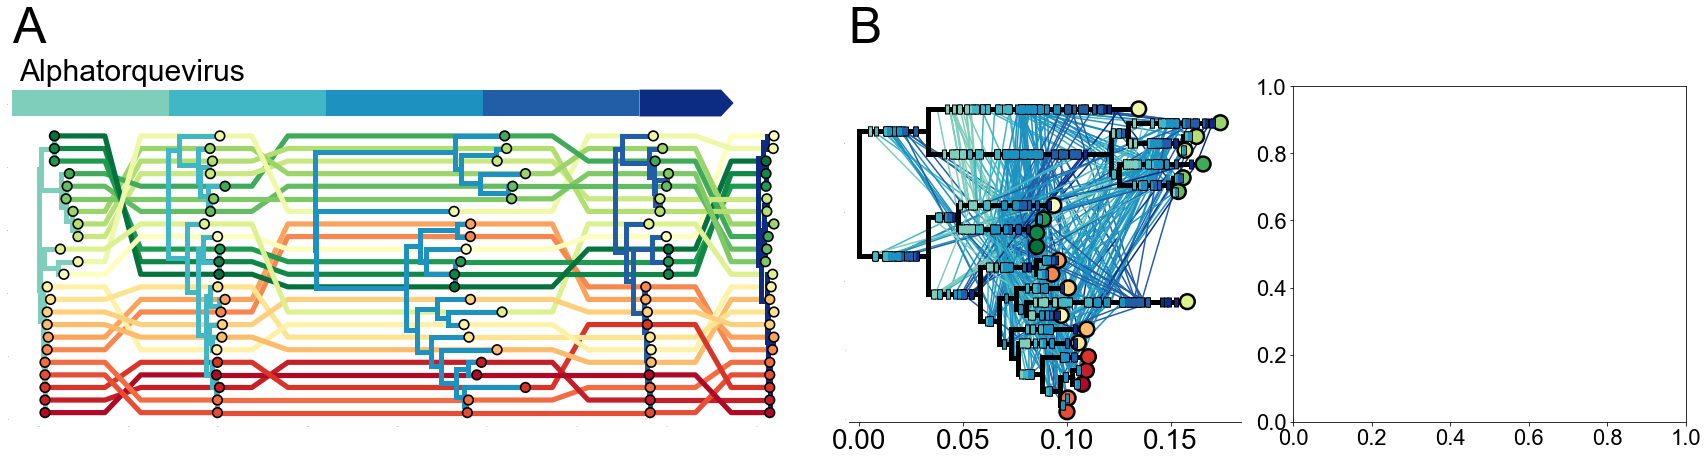

In [9]:
fig = plt.figure(figsize=(30, 20),facecolor='w') ## start plot
gs = gridspec.GridSpec(3,3,height_ratios=[1,1,1],width_ratios=[2,1,1],wspace=0.1,hspace=0.12) 

cmap=mpl.cm.twilight

chunk_colours={(0,500): '#7fcdbb', 
               (500,1000): '#41b6c4', 
               (1000,1500): '#1d91c0', 
               (1500,2000): '#225ea8', 
               (2000,2300): '#0c2c84'}

for g,G in enumerate(sorted(tanglegram_trees)): ## iterate over genera
    print(G)
    
    tanglegram_cmap=mpl.cm.RdYlGn
    branch_cmap=mpl.cm.cividis
    
    untangled=tanglegram_trees[G]
    
    ax=plt.subplot(gs[g,0],facecolor='w')
    
    offset=0
    gap=0.2
    tip_positions={}
    for t,tr in enumerate(untangled): ## iterate over trees
        tr.sortBranches()
        x_attr=lambda k: k.height + offset ## offset tree

        tip_positions[tr]={k.name: (x_attr(k),k.y) for k in tr.getExternal()}
        
        fc=lambda k: tanglegram_cmap(tip_positions[untangled[0]][k.name][1]/tr.ySpan)
        s=20+(1000/len(tr.getExternal()))
        
        tr.plotTree(ax,x_attr=x_attr,width=5,colour=[chunk_colours[c] for c in sorted(chunk_colours,key=lambda w: w[0])][t]) ## plot tree
        tr.plotPoints(ax,x_attr=x_attr,size=s,colour=fc)
        
        sorted_chunks=sorted(chunk_colours,key=lambda w: w[0])
        x=sorted_chunks[t][0]/2500
        y=0.95
        dx=(sorted_chunks[t][1]-sorted_chunks[t][0])/2500
        dy=0
        w=0.08
        hL=0.0
        if t==len(untangled)-1: ## if at last chunk make arrow pointed
            hL=40/2500
        
        ax.arrow(x,y,dx,dy,facecolor=chunk_colours[sorted_chunks[t]],edgecolor='none', 
                 width=w,length_includes_head=True,head_length=hL,head_width=w,transform=ax.transAxes)
        
        offset+=tr.treeHeight+gap
    
    for this_tree,next_tree in zip(untangled,untangled[1:]): ## iterate over pairs of adjacent trees
        for k in this_tree.getExternal():
            x1,y1=tip_positions[this_tree][k.name]
            x2,y2=tip_positions[next_tree][k.name]

            matching_tip=next_tree.getBranches(lambda w: w.branchType=='leaf' and w.name==k.name)

            fr=0.3
            fc=tanglegram_cmap(tip_positions[untangled[0]][matching_tip.name][1]/this_tree.ySpan)
            highest_tip=max(tip_positions[this_tree].values())
            
            lw=3+(50/len(tip_positions[this_tree].keys()))
            
            ax.plot([x1,highest_tip[0]+fr*gap,x2-matching_tip.height-fr*gap,x2],[y1,y1,y2,y2],color=fc,lw=lw,alpha=1.0,zorder=0)
    
    ax.plot()
    ax.tick_params(labelsize=0,size=0)
    [ax.spines[loc].set_visible(False) for loc in ax.spines]
    
    ax.set_xlim(-0.06,offset-gap+0.05)
    ax.set_ylim(-tr.ySpan*0.01,tr.ySpan*1.15)
    
    if G=='Alpha':
        ax.text(0.0,1.1,'A',size=50,ha='left',va='bottom',transform=ax.transAxes)
        
    ax.text(0.01,1.0,'%storquevirus'%(G),size=30,ha='left',va='bottom',transform=ax.transAxes)
    
    ########################
    ax=plt.subplot(gs[g,1],facecolor='w')
    
    ll=homoplasy_trees[G]
    
    first_tree_ys={k.name: k.y for k in tanglegram_trees[G][0].getExternal()}
    
    fc=lambda k: tanglegram_cmap(first_tree_ys[k.name]/ll.ySpan) if k.name in first_tree_ys else 'grey'
    
    ll.plotTree(ax,colour='k',width=5) ## plot tree
    
    s=20+(3000/len(ll.getExternal())) ## tip size depends on total number of tips in tree
    ll.plotPoints(ax,colour=fc,size=s) ## colour tips based on their y position in the first tree
    
    homoplasy_lines=[]
    
    xs={t: [] for t in chunk_colours}
    ys={t: [] for t in chunk_colours}
    for mu in synapomorphy_branches[G]:
        k=synapomorphy_branches[G][mu]
        site=int(mu[1:-1])
        fromM=mu[0]
        toM=mu[-1]
        
        frac=site/len(k.traits['sequence'])
        for interval in chunk_colours:
            i,j=interval
            if i<site<=j:
                xs[interval].append(k.parent.x+k.length*frac)
                ys[interval].append(k.y)
    
    for interval in chunk_colours:
        fc=chunk_colours[interval]
        ax.scatter(xs[interval],ys[interval],s=80,facecolor=fc,lw=3,marker='|',zorder=100)
        ax.scatter(xs[interval],ys[interval],s=90,facecolor='k',lw=5,marker='|',zorder=99)
    
    max_homoplasy=max(map(len,homoplasy_branches[G].values()))
    for mu in homoplasy_branches[G]: ## iterate over mutations on homoplasious branches
        sorted_branches=sorted(homoplasy_branches[G][mu],key=lambda w: w.height) ## all branches with same mutation
        for b1,b2 in zip(sorted_branches,sorted_branches[1:]): ## only do pairs of branches, not even all branches (because space is limited)
            site=int(mu[1:-1])
            fromM=mu[0]
            toM=mu[-1]

            frac=site/len(b1.traits['sequence'])
            x1=b1.parent.x+b1.length*frac
            y1=b1.y
            
            x2=b2.parent.x+b2.length*frac
            y2=b2.y
            
            for interval in chunk_colours:
                i,j=interval
                if i<site<=j: ## get interval colour
                    fc=chunk_colours[interval]
            ax.plot([x1,x2],[y1,y2],color=fc,alpha=1.0,zorder=0)
    
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=28)
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    
    if G=='Gamma':
        ax.set_xlabel('divergence (nt subs/site)',size=26)
    
    elif G=='Alpha':
        ax.text(0.0,1.1,'B',size=50,ha='left',va='bottom',transform=ax.transAxes)
    
    ax.set_xlim(-0.005,ll.treeHeight+0.01)
    ax.set_ylim(-ll.ySpan*0.01,ll.ySpan*1.05)
    
    #########################
    ax=plt.subplot(gs[g,2],facecolor='w')
    pairs=[(i,j) for i in columns[G] for j in columns[G] if j>i and np.isnan(LD[G][i][j])==False] ## get all pairs of sites that have measured LD

    xs=np.array(list(map(np.diff,pairs)))
    xs=xs.reshape(len(xs))

    ys=np.array([LD[G][x[0]][x[1]] for x in pairs])
    
    bins=np.arange(0,max(xs),100) ## bin LD values according to distance
    binned={i: [] for i in range(len(bins)+1)}
    idx=np.digitize(xs,bins)
    for i,x in enumerate(idx):
        binned[x].append(ys[i])
        
    ax.step(bins,[np.mean(binned[i]) for i in range(len(bins))],color='indianred',lw=5,zorder=100) ## plot mean of each bin
    ax.scatter(xs,ys,s=20,c='k',edgecolor='none',alpha=1.0) ## plot all LD data
    
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
    
    ax.set_xlim(-10,max(xs)+10)
    ax.set_ylim(-0.01,1.01)
    
    ax.grid(axis='y',ls='--',color='grey')
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc in ['top','left']]
    ax.tick_params(labelsize=30)
    
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    
    if G=='Gamma':
        ax.set_ylabel(r'LD ($\chi^{2}_{df}$)',size=30)
        ax.set_xlabel('distance between sites',size=30)
    else:
        ax.tick_params(axis='y',size=0,labelsize=0)
        if G=='Alpha':
            ax.text(0.0,1.1,'C',size=50,ha='left',va='bottom',transform=ax.transAxes)
            
plt.savefig(os.path.join(base_path, 'figures', 'figure_4_recombination.pdf'),dpi=300,bbox_inches='tight')
plt.savefig(os.path.join(base_path, 'figures', 'figure_4_recombination.png'),dpi=300,bbox_inches='tight')
plt.show()